In [108]:
# Plotting stuff
import numpy as np
import matplotlib.pyplot as plt

# Pytorch related imports
import torch
import torch.nn as nn
from torch import cuda, optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# Setting random seeds for reproducability
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Flags for CUDA-sided deterministic results
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **Notes**
imgs/ -> Contains the images rendered through this notebook and used for the report as well \
statedicts/ -> Contains the state dictionaries of the models, these were used to load the models for testing purposes after training was complete

## Denoising Autoencoder Architecture
A Denoising Autoencoder is composed of an encoder and a decoder. The encoder converts the input image to the latent space whereas the decoder converts the latent space to the output. The latent space is a low dimensional subspace which typically had high information concentration.

In [109]:
#########################################################################
################# Define Denoising Autoencoder Structure ################
#########################################################################
class DAE(nn.Module):
    def __init__(self, encoder_layers, decoder_layers, name):
        super(DAE, self).__init__()
        self.model_name = name
        # Encoder is a stack of layers as per nn.Sequential
        self.encoder = encoder_layers
        # Decoder is a stack of layers as per nn.Sequential
        self.decoder = decoder_layers

    def forward(self, x):
        # Encode to latent space
        x = self.encoder(x)
        # Decode from latent space
        x = self.decoder(x)
        return x

## Architectures for the 5 layer case
The three architectures in this cell use 5 Convolutional Layers in the endcoder side and 5 Transpose Convolutional Layers on the decoder side.
They have latent spaces of size (4, 13, 13), (4, 8, 8), and (4, 5, 5)

In [110]:
#########################################################################
############### Define Architectures for the 5 layer case ###############
#########################################################################

# 5 Layer Network with latent space size reduction (1, 28, 28) -> (4, 5, 5)
seq5_5_5 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=6, kernel_size=5),
      nn.ReLU(),
      nn.Conv2d(in_channels=6, out_channels=4, kernel_size=6),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=6, kernel_size=6),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=6, out_channels=8, kernel_size=5),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=6),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=5),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=6),
      nn.Sigmoid()
  )
}

# 5 Layer Network with latent space size reduction (1, 28, 28) -> (4, 8, 8)
seq5_8_8 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=6, kernel_size=5),
      nn.ReLU(),
      nn.Conv2d(in_channels=6, out_channels=4, kernel_size=5),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=6, kernel_size=5),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=6, out_channels=8, kernel_size=5),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=5),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=5),
      nn.Sigmoid()
  )
}

# 5 Layer Network with latent space size reduction (1, 28, 28) -> (4, 13, 13)
seq5_13_13 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=6, kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(in_channels=6, out_channels=4, kernel_size=4),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=6, kernel_size=4),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=6, out_channels=8, kernel_size=4),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=4),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4),
      nn.Sigmoid()
  )
}

## Architectures for the 3 layer case
The three architectures in this cell use 3 Convolutional Layers in the endcoder side and 3 Transpose Convolutional Layers on the decoder side.
They have latent spaces of size (4, 13, 13), (4, 8, 8), and (4, 5, 5)

In [111]:
#########################################################################
############### Define Architectures for the 3 layer case ###############
#########################################################################

# 3 Layer Network with latent space size reduction (1, 28, 28) -> (4, 5, 5)
seq3_5_5 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=8),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=4, kernel_size=9),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=9),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=8),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=9),
      nn.Sigmoid()
  )
}

# 3 Layer Network with latent space size reduction (1, 28, 28) -> (4, 8, 8)
seq3_8_8 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=8),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=4, kernel_size=7),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=7),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=8),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=8),
      nn.Sigmoid()
  )
}

# 3 Layer Network with latent space size reduction (1, 28, 28) -> (4, 13, 13)
seq3_13_13 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=4, kernel_size=6),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=6),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=6),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=6),
      nn.Sigmoid()
  )
}

## Architectures for the 1 layer case
The three architectures in this cell use 1 Convolutional Layer in the endcoder side and 1 Transpose Convolutional Layer on the decoder side.
They have latent spaces of size (4, 13, 13), (4, 8, 8), and (4, 5, 5)

In [112]:
#########################################################################
############### Define Architectures for the 1 layer case ###############
#########################################################################

# 1 Layer Network with latent space size reduction (1, 28, 28) -> (4, 5, 5)
seq1_5_5 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=24),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=24),
      nn.Sigmoid()
  )
}

# 3 Layer Network with latent space size reduction (28, 28) -> (8, 8)
seq1_8_8 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=21),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=21),
      nn.Sigmoid()
  )
}

# 3 Layer Network with latent space size reduction (28, 28) -> (13, 13)
seq1_13_13 = {
  "encoder": nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=16),
      nn.ReLU()
  ),
  "decoder": nn.Sequential(
      nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=16),
      nn.Sigmoid()
  )
}

## Denoiser Pipeline
The Denoiser Pipeline is the heart of this assignment. It contains the configuration to set up a model alongside a loss function and optimizer and begin training the model. It exposes these relevant interfaces: \
1- train_model -> This is used to train a model for a given number of epochs \
2- evaluate_test_model_loss -> This is used to aggregate the loss on test data for a trained model \
3- apply_noise -> This is used to implant noise artificially to the original MNIST data \
4- prepara_dataloaders -> This is used to create all the train, validation and test loader \
This pipeline also contains a few handy helper functions for plotting purposes.

In [130]:
#########################################################################
################### Define Denoiser Training Pipeline ###################
#########################################################################
class DenoiserPipeline:

  def __init__(self, model, optimizer, loss_fn):
    '''Constructor For Training Pipeline'''
    self.model = model
    self.optim = optimizer
    self.criterion = loss_fn
    self.gpu_present = cuda.is_available()

  def train_model(self, train_dataloader, valid_dataloader, n_epochs):
    '''
      Model Training and Validation Method
      Demands as args train + validation loader and number of epochs to train for
    '''

    print(f"GPU Present: {self.gpu_present}")

    # Move model and data to CUDA if it is present
    if self.gpu_present:
      self.model = self.model.cuda()

    train_loss_history = []
    valid_loss_history = []

    for epoch in range(1, n_epochs+1):

      train_loss = 0.0
      valid_loss = 0.0

      ################ Run Model Training ################
      # Set model in training mode
      self.model.train(True)

      for data, _ in train_dataloader:

        # Apply noise and ensure input data is loaded on gpu
        noisy_data = DenoiserPipeline.apply_noise(data)
        if self.gpu_present:
          noisy_data = noisy_data.cuda()
          data = data.cuda()

        # Clear all gradients
        self.optim.zero_grad()
        # Forward pass
        output = self.model(noisy_data)
        # Collect loss - This compares to the original data
        loss = self.criterion(output, data)
        # Backward pass
        loss.backward()
        # Update network based on gradients
        self.optim.step()

        train_loss += loss.item() * data.size(0)

      ############### Run Model Validation ###############

      # Do not track gradients
      with torch.no_grad():

        # Set model to evaluation mode - no longer training
        self.model.eval()

        for val_data, _ in valid_dataloader:

          # Apply noise and ensure input data is loaded on gpu
          val_noisy_data = DenoiserPipeline.apply_noise(val_data)
          if self.gpu_present:
            val_noisy_data = val_noisy_data.cuda()
            val_data = val_data.cuda()

          # Denoise input to autoencoder
          val_output = self.model(val_noisy_data)
          # Collect loss - This compares to the original data
          val_loss = self.criterion(val_output, val_data)

          valid_loss += val_loss.item() * val_data.size(0)

      train_loss = train_loss / len(train_dataloader.dataset)
      valid_loss = valid_loss / len(valid_dataloader.dataset)

      # Report loss for training and validation
      print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')

      train_loss_history.append(train_loss)
      valid_loss_history.append(valid_loss)

    return train_loss_history, valid_loss_history

  @staticmethod
  def evaluate_test_model_loss(model, loss_fn, test_loader, cuda_available):
    '''
      Evaluate given model on test data based on the provided criterion loss_fn
      In the context of denoising, there is no proper accuracy to report since
      we do not do any proper prediction of a target output or class like in
      regression or classification therefore we report test loss as our metric
    '''

    # Test loss is set to 0 initially
    test_loss = 0.0
    # Don't need to keep track of gradients for testing
    with torch.no_grad():
      if cuda_available:
        model = model.cuda()
      model.eval()

      # Test Loop
      for data, _ in test_loader:

        # Apply noise
        noisy_data = DenoiserPipeline.apply_noise(data)

        # Load to GPU
        if cuda_available:
          noisy_data = noisy_data.cuda()
          data = data.cuda()

        output = model(noisy_data)
        # Collect loss - This compares to the original data
        loss = loss_fn(output, data)

        test_loss += loss.item() * data.size(0)

      test_loss = test_loss / len(test_loader.dataset)
      return test_loss

  @staticmethod
  def apply_noise(original_data):
    '''
      General Purpose Noise Generation Function - Generates Gaussian Noise
      Declared as a static method so it can be easily used outside the class too
    '''

    # Add random noise to original data and then clamp the data to [0, 1] range
    noisy_data = original_data + 0.5*torch.randn(original_data.size())
    return torch.clamp(noisy_data, 0, 1)

  @staticmethod
  def prepare_dataloaders(train_split=0.8, download=True, batch_size=64):
    '''
      General Purpose Data Loader Function - can be used outside the class too as
      a static method without the need for an instance.
      Performs max-min normalization followed by mean-stdev normalization.
      Train size split defaults to 0.8
      Batch size defaults to 64
    '''

    transform = transforms.Compose(
        [
          transforms.ToTensor()
        ]
    )

    # Load and split datasets into train, validation, and testing
    dataset = datasets.MNIST('../data', train=True, download=download, transform=transform)
    train_size = int(train_split*len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    test_dataset = datasets.MNIST('../data', train=False, transform=transform)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(val_dataset,batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size)

    return train_loader, valid_loader, test_loader


  @staticmethod
  def plot_train_valid_history_for_model_architecture(title, train_histories, valid_histories):
    '''
      Custom plot function to compare original, noisy, and denoised images from
      different architectures. It violates DRY principle of clean code :( but I
      really needed a very specific format for plotting, sorry :(
    '''

    plt.plot(train_histories[0], label='Train Loss DAE13x13')
    plt.plot(valid_histories[0], label='Valid Loss DAE13x13')
    plt.plot(train_histories[1], label='Train Loss DAE8x8')
    plt.plot(valid_histories[1], label='Valid Loss DAE8x8')
    plt.plot(train_histories[2], label='Train Loss DAE5x5')
    plt.plot(valid_histories[2], label='Valid Loss DAE5x5')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE) Loss')
    plt.title(title)
    plt.legend()

    plt.show()


  @staticmethod
  def plot_triple_original_noisy_reconstructed(title, original_data, noisy_data, denoised_1, denoised_2):
    '''
      Custom plot function to compare original, noisy, and denoised images from
      different architectures. It violates DRY principle of clean code :( but I
      really needed a very specific format for plotting, sorry :(
    '''

    fig, axarr = plt.subplots(2, 5)
    fig.suptitle(title, x=0.51, y=0.95)

    titles = 2 * ["Original", "Noisy",
              "DAE13x13", "DAE8x8", "DAE5x5"]
    imgs = [original_data[0], noisy_data[0],
            denoised_1[0], denoised_1[1], denoised_1[2],
            original_data[1], noisy_data[1],
            denoised_2[0], denoised_2[1], denoised_2[2]]
    imgs_squeezed = [img.squeeze() for img in imgs]

    for i, ax in enumerate(axarr.flat):
      ax.set_axis_off()
      ax.imshow(imgs_squeezed[i])
      ax.set_title(titles[i])

    plt.show()

  @staticmethod
  def plot_test_accuracies(all_losses):
    '''
      Custom plot function to display bar chart for the test MSE losses. This
      function expects relies on an input that maps all 9 model architectures.
      It color matches by latent space to provide a benchmark to compare models
      not only between the same depth but also between the same latent space size.

    '''

    color_palette = ['blue', 'orange', 'green']
    plt.bar(all_losses.keys(), all_losses.values(), color=color_palette * 4)

    plt.xlabel('Model Architecture Name')
    plt.xticks(rotation='vertical')
    plt.ylabel('Model MSE Loss')
    plt.title('Test Data Losses for All Denoising AutoEncoders')

    legend_labels = ['13x13 Latent Space', '8x8 Latent Space', '5x5 Latent Space']
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_palette]
    plt.legend(legend_handles, legend_labels)

    # Displaying the plot
    plt.show()

In [114]:
############### LOADING TRAIN, VALIDATION, AND TEST DATA ###############
train_loader, val_loader, test_loader = DenoiserPipeline.prepare_dataloaders()

############### Test Iterator for Visualization Purposes ###############
testiter = iter(test_loader)
images, labels = next(testiter)
noisy = DenoiserPipeline.apply_noise(images)

In [20]:
############### Train first 5 layer model with latent space 13x13 ###############
DAE_5_13 = DAE(seq5_13_13["encoder"], seq5_13_13["decoder"], "DAE_5_13")
denoise_pipeline_5_13 = DenoiserPipeline(DAE_5_13, torch.optim.Adam(DAE_5_13.parameters()), nn.MSELoss())
train_hist_5_13, val_hist_5_13 = denoise_pipeline_5_13.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0328 	Validation Loss: 0.0165

Epoch: 2 	Training Loss: 0.0155 	Validation Loss: 0.0146

Epoch: 3 	Training Loss: 0.0142 	Validation Loss: 0.0139

Epoch: 4 	Training Loss: 0.0135 	Validation Loss: 0.0133

Epoch: 5 	Training Loss: 0.0131 	Validation Loss: 0.0128

Epoch: 6 	Training Loss: 0.0127 	Validation Loss: 0.0126

Epoch: 7 	Training Loss: 0.0124 	Validation Loss: 0.0123

Epoch: 8 	Training Loss: 0.0122 	Validation Loss: 0.0122

Epoch: 9 	Training Loss: 0.0120 	Validation Loss: 0.0120

Epoch: 10 	Training Loss: 0.0119 	Validation Loss: 0.0118

Epoch: 11 	Training Loss: 0.0117 	Validation Loss: 0.0118

Epoch: 12 	Training Loss: 0.0117 	Validation Loss: 0.0116

Epoch: 13 	Training Loss: 0.0116 	Validation Loss: 0.0116

Epoch: 14 	Training Loss: 0.0115 	Validation Loss: 0.0115

Epoch: 15 	Training Loss: 0.0114 	Validation Loss: 0.0114


In [46]:
############### Train second 5 layer model with latent space 8x8 ###############
DAE_5_8 = DAE(seq5_8_8["encoder"], seq5_8_8["decoder"], "DAE_5_8")
denoise_pipeline_5_8 = DenoiserPipeline(DAE_5_8, torch.optim.Adam(DAE_5_8.parameters()), nn.MSELoss())
train_hist_5_8, val_hist_5_8 = denoise_pipeline_5_8.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0456 	Validation Loss: 0.0238

Epoch: 2 	Training Loss: 0.0203 	Validation Loss: 0.0184

Epoch: 3 	Training Loss: 0.0178 	Validation Loss: 0.0171

Epoch: 4 	Training Loss: 0.0166 	Validation Loss: 0.0165

Epoch: 5 	Training Loss: 0.0160 	Validation Loss: 0.0157

Epoch: 6 	Training Loss: 0.0154 	Validation Loss: 0.0154

Epoch: 7 	Training Loss: 0.0149 	Validation Loss: 0.0145

Epoch: 8 	Training Loss: 0.0144 	Validation Loss: 0.0144

Epoch: 9 	Training Loss: 0.0141 	Validation Loss: 0.0139

Epoch: 10 	Training Loss: 0.0139 	Validation Loss: 0.0138

Epoch: 11 	Training Loss: 0.0136 	Validation Loss: 0.0138

Epoch: 12 	Training Loss: 0.0134 	Validation Loss: 0.0135

Epoch: 13 	Training Loss: 0.0132 	Validation Loss: 0.0135

Epoch: 14 	Training Loss: 0.0131 	Validation Loss: 0.0131

Epoch: 15 	Training Loss: 0.0129 	Validation Loss: 0.0129


In [22]:
############### Train third 5 layer model with latent space 5x5 ###############
DAE_5_5 = DAE(seq5_5_5["encoder"], seq5_5_5["decoder"], "DAE_5_5")
denoise_pipeline_5_5 = DenoiserPipeline(DAE_5_5, torch.optim.Adam(DAE_5_5.parameters()), nn.MSELoss())
train_hist_5_5, val_hist_5_5 = denoise_pipeline_5_5.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0566 	Validation Loss: 0.0376

Epoch: 2 	Training Loss: 0.0321 	Validation Loss: 0.0292

Epoch: 3 	Training Loss: 0.0271 	Validation Loss: 0.0257

Epoch: 4 	Training Loss: 0.0249 	Validation Loss: 0.0264

Epoch: 5 	Training Loss: 0.0235 	Validation Loss: 0.0225

Epoch: 6 	Training Loss: 0.0225 	Validation Loss: 0.0219

Epoch: 7 	Training Loss: 0.0217 	Validation Loss: 0.0214

Epoch: 8 	Training Loss: 0.0210 	Validation Loss: 0.0208

Epoch: 9 	Training Loss: 0.0204 	Validation Loss: 0.0203

Epoch: 10 	Training Loss: 0.0200 	Validation Loss: 0.0201

Epoch: 11 	Training Loss: 0.0196 	Validation Loss: 0.0194

Epoch: 12 	Training Loss: 0.0193 	Validation Loss: 0.0199

Epoch: 13 	Training Loss: 0.0190 	Validation Loss: 0.0189

Epoch: 14 	Training Loss: 0.0188 	Validation Loss: 0.0190

Epoch: 15 	Training Loss: 0.0186 	Validation Loss: 0.0186


In [47]:
denoised_5_13 = DAE_5_13(noisy.cuda()).cpu().detach()
denoised_5_8 = DAE_5_8(noisy.cuda()).cpu().detach()
denoised_5_5 = DAE_5_5(noisy.cuda()).cpu().detach()

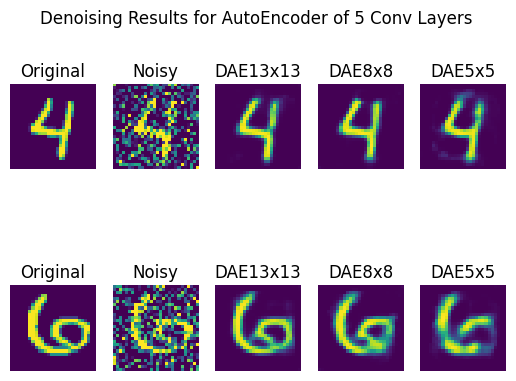

In [51]:
DenoiserPipeline.plot_triple_original_noisy_reconstructed(
    "Denoising Results for AutoEncoder of 5 Conv Layers",
    [images[27], images[54]],
    [noisy[27], noisy[54]],
    [denoised_5_13[27], denoised_5_8[27], denoised_5_5[27]],
    [denoised_5_13[54], denoised_5_8[54], denoised_5_5[54]]
)

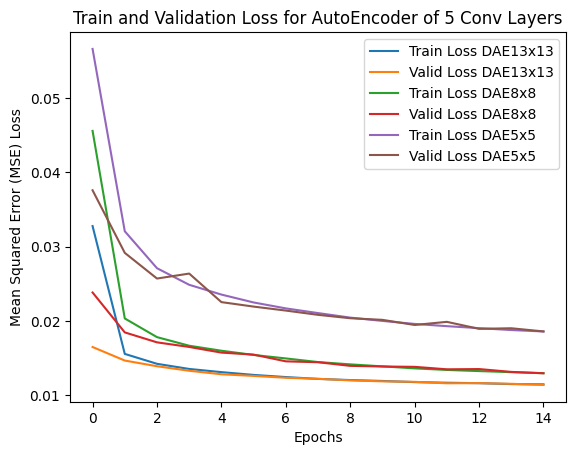

In [50]:
DenoiserPipeline.plot_train_valid_history_for_model_architecture(
    "Train and Validation Loss for AutoEncoder of 5 Conv Layers",
    train_histories = [train_hist_5_13, train_hist_5_8, train_hist_5_5],
    valid_histories = [val_hist_5_13, val_hist_5_8, val_hist_5_5]
)

In [115]:
############### Train first 3 layer model with latent space 13x13 ###############
DAE_3_13 = DAE(seq3_13_13["encoder"], seq3_13_13["decoder"], "DAE_3_13")
denoise_pipeline_3_13 = DenoiserPipeline(DAE_3_13, torch.optim.Adam(DAE_3_13.parameters()), nn.MSELoss())
train_hist_3_13, val_hist_3_13 = denoise_pipeline_3_13.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0366 	Validation Loss: 0.0206

Epoch: 2 	Training Loss: 0.0194 	Validation Loss: 0.0182

Epoch: 3 	Training Loss: 0.0179 	Validation Loss: 0.0173

Epoch: 4 	Training Loss: 0.0170 	Validation Loss: 0.0166

Epoch: 5 	Training Loss: 0.0165 	Validation Loss: 0.0163

Epoch: 6 	Training Loss: 0.0162 	Validation Loss: 0.0158

Epoch: 7 	Training Loss: 0.0158 	Validation Loss: 0.0153

Epoch: 8 	Training Loss: 0.0145 	Validation Loss: 0.0135

Epoch: 9 	Training Loss: 0.0134 	Validation Loss: 0.0133

Epoch: 10 	Training Loss: 0.0131 	Validation Loss: 0.0130

Epoch: 11 	Training Loss: 0.0128 	Validation Loss: 0.0126

Epoch: 12 	Training Loss: 0.0126 	Validation Loss: 0.0125

Epoch: 13 	Training Loss: 0.0125 	Validation Loss: 0.0122

Epoch: 14 	Training Loss: 0.0124 	Validation Loss: 0.0124

Epoch: 15 	Training Loss: 0.0122 	Validation Loss: 0.0122


In [29]:
############### Train second 3 layer model with latent space 8x8 ###############
DAE_3_8 = DAE(seq3_8_8["encoder"], seq3_8_8["decoder"], "DAE_3_8")
denoise_pipeline_3_8 = DenoiserPipeline(DAE_3_8, torch.optim.Adam(DAE_3_8.parameters()), nn.MSELoss())
train_hist_3_8, val_hist_3_8 = denoise_pipeline_3_8.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0572 	Validation Loss: 0.0385

Epoch: 2 	Training Loss: 0.0304 	Validation Loss: 0.0269

Epoch: 3 	Training Loss: 0.0252 	Validation Loss: 0.0242

Epoch: 4 	Training Loss: 0.0232 	Validation Loss: 0.0226

Epoch: 5 	Training Loss: 0.0219 	Validation Loss: 0.0216

Epoch: 6 	Training Loss: 0.0211 	Validation Loss: 0.0209

Epoch: 7 	Training Loss: 0.0204 	Validation Loss: 0.0202

Epoch: 8 	Training Loss: 0.0200 	Validation Loss: 0.0199

Epoch: 9 	Training Loss: 0.0195 	Validation Loss: 0.0192

Epoch: 10 	Training Loss: 0.0192 	Validation Loss: 0.0191

Epoch: 11 	Training Loss: 0.0189 	Validation Loss: 0.0189

Epoch: 12 	Training Loss: 0.0186 	Validation Loss: 0.0186

Epoch: 13 	Training Loss: 0.0184 	Validation Loss: 0.0183

Epoch: 14 	Training Loss: 0.0181 	Validation Loss: 0.0182

Epoch: 15 	Training Loss: 0.0180 	Validation Loss: 0.0178


In [30]:
############### Train third 3 layer model with latent space 5x5 ###############
DAE_3_5 = DAE(seq3_5_5["encoder"], seq3_5_5["decoder"], "DAE_3_5")
denoise_pipeline_3_5 = DenoiserPipeline(DAE_3_5, torch.optim.Adam(DAE_3_5.parameters()), nn.MSELoss())
train_hist_3_5, val_hist_3_5 = denoise_pipeline_3_5.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0668 	Validation Loss: 0.0517

Epoch: 2 	Training Loss: 0.0486 	Validation Loss: 0.0459

Epoch: 3 	Training Loss: 0.0451 	Validation Loss: 0.0437

Epoch: 4 	Training Loss: 0.0431 	Validation Loss: 0.0423

Epoch: 5 	Training Loss: 0.0416 	Validation Loss: 0.0419

Epoch: 6 	Training Loss: 0.0405 	Validation Loss: 0.0403

Epoch: 7 	Training Loss: 0.0394 	Validation Loss: 0.0395

Epoch: 8 	Training Loss: 0.0384 	Validation Loss: 0.0380

Epoch: 9 	Training Loss: 0.0376 	Validation Loss: 0.0372

Epoch: 10 	Training Loss: 0.0370 	Validation Loss: 0.0367

Epoch: 11 	Training Loss: 0.0333 	Validation Loss: 0.0314

Epoch: 12 	Training Loss: 0.0305 	Validation Loss: 0.0305

Epoch: 13 	Training Loss: 0.0294 	Validation Loss: 0.0291

Epoch: 14 	Training Loss: 0.0284 	Validation Loss: 0.0282

Epoch: 15 	Training Loss: 0.0278 	Validation Loss: 0.0277


In [117]:
denoised_3_13 = DAE_3_13(noisy.cuda()).cpu().detach()
denoised_3_8 = DAE_3_8(noisy.cuda()).cpu().detach()
denoised_3_5 = DAE_3_5(noisy.cuda()).cpu().detach()

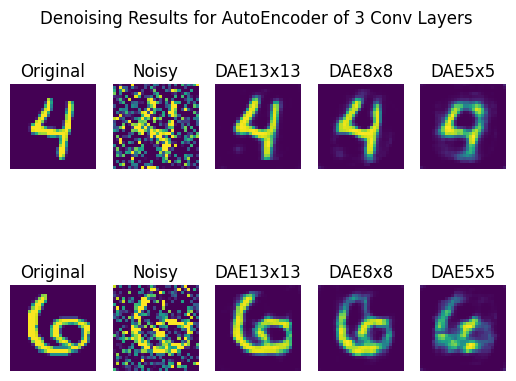

In [133]:
DenoiserPipeline.plot_triple_original_noisy_reconstructed(
    "Denoising Results for AutoEncoder of 3 Conv Layers",
    [images[27], images[54]],
    [noisy[27], noisy[54]],
    [denoised_3_13[27], denoised_3_8[27], denoised_3_5[27]],
    [denoised_3_13[54], denoised_3_8[54], denoised_3_5[54]]
)

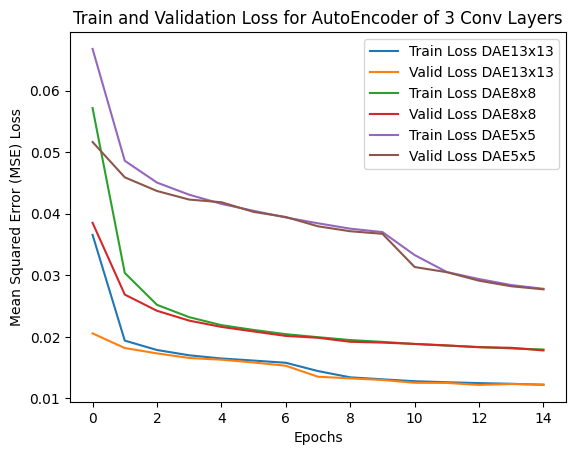

In [132]:
DenoiserPipeline.plot_train_valid_history_for_model_architecture(
    "Train and Validation Loss for AutoEncoder of 3 Conv Layers",
    train_histories = [train_hist_3_13, train_hist_3_8, train_hist_3_5],
    valid_histories = [val_hist_3_13, val_hist_3_8, val_hist_3_5]
)

In [75]:
############### Train first 1 layer model with latent space 13x13 ###############
DAE_1_13 = DAE(seq1_13_13["encoder"], seq1_13_13["decoder"], "DAE_1_13")
denoise_pipeline_1_13 = DenoiserPipeline(DAE_1_13, torch.optim.Adam(DAE_1_13.parameters()), nn.MSELoss())
train_hist_1_13, val_hist_1_13 = denoise_pipeline_1_13.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0477 	Validation Loss: 0.0282

Epoch: 2 	Training Loss: 0.0251 	Validation Loss: 0.0227

Epoch: 3 	Training Loss: 0.0216 	Validation Loss: 0.0208

Epoch: 4 	Training Loss: 0.0203 	Validation Loss: 0.0200

Epoch: 5 	Training Loss: 0.0197 	Validation Loss: 0.0194

Epoch: 6 	Training Loss: 0.0193 	Validation Loss: 0.0190

Epoch: 7 	Training Loss: 0.0189 	Validation Loss: 0.0188

Epoch: 8 	Training Loss: 0.0187 	Validation Loss: 0.0185

Epoch: 9 	Training Loss: 0.0184 	Validation Loss: 0.0183

Epoch: 10 	Training Loss: 0.0183 	Validation Loss: 0.0181

Epoch: 11 	Training Loss: 0.0180 	Validation Loss: 0.0180

Epoch: 12 	Training Loss: 0.0179 	Validation Loss: 0.0179

Epoch: 13 	Training Loss: 0.0178 	Validation Loss: 0.0178

Epoch: 14 	Training Loss: 0.0177 	Validation Loss: 0.0176

Epoch: 15 	Training Loss: 0.0177 	Validation Loss: 0.0176


In [37]:
############### Train second 1 layer model with latent space 8x8 ###############
DAE_1_8 = DAE(seq1_8_8["encoder"], seq1_8_8["decoder"], "DAE_1_8")
denoise_pipeline_1_8 = DenoiserPipeline(DAE_1_8, torch.optim.Adam(DAE_1_8.parameters()), nn.MSELoss())
train_hist_1_8, val_hist_1_8 = denoise_pipeline_1_8.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0401 	Validation Loss: 0.0396

Epoch: 2 	Training Loss: 0.0355 	Validation Loss: 0.0313

Epoch: 3 	Training Loss: 0.0301 	Validation Loss: 0.0295

Epoch: 4 	Training Loss: 0.0289 	Validation Loss: 0.0285

Epoch: 5 	Training Loss: 0.0281 	Validation Loss: 0.0279

Epoch: 6 	Training Loss: 0.0276 	Validation Loss: 0.0276

Epoch: 7 	Training Loss: 0.0273 	Validation Loss: 0.0273

Epoch: 8 	Training Loss: 0.0270 	Validation Loss: 0.0270

Epoch: 9 	Training Loss: 0.0269 	Validation Loss: 0.0270

Epoch: 10 	Training Loss: 0.0267 	Validation Loss: 0.0266

Epoch: 11 	Training Loss: 0.0266 	Validation Loss: 0.0266

Epoch: 12 	Training Loss: 0.0266 	Validation Loss: 0.0267

Epoch: 13 	Training Loss: 0.0264 	Validation Loss: 0.0265

Epoch: 14 	Training Loss: 0.0264 	Validation Loss: 0.0263

Epoch: 15 	Training Loss: 0.0263 	Validation Loss: 0.0264


In [38]:
############### Train third 1 layer model with latent space 5x5 ###############
DAE_1_5 = DAE(seq1_5_5["encoder"], seq1_5_5["decoder"], "DAE_1_5")
denoise_pipeline_1_5 = DenoiserPipeline(DAE_1_5, torch.optim.Adam(DAE_1_5.parameters()), nn.MSELoss())
train_hist_1_5, val_hist_1_5 = denoise_pipeline_1_5.train_model(train_loader, val_loader, n_epochs=15)

GPU Present: True

Epoch: 1 	Training Loss: 0.0597 	Validation Loss: 0.0488

Epoch: 2 	Training Loss: 0.0471 	Validation Loss: 0.0459

Epoch: 3 	Training Loss: 0.0452 	Validation Loss: 0.0448

Epoch: 4 	Training Loss: 0.0446 	Validation Loss: 0.0444

Epoch: 5 	Training Loss: 0.0442 	Validation Loss: 0.0441

Epoch: 6 	Training Loss: 0.0439 	Validation Loss: 0.0437

Epoch: 7 	Training Loss: 0.0434 	Validation Loss: 0.0432

Epoch: 8 	Training Loss: 0.0426 	Validation Loss: 0.0421

Epoch: 9 	Training Loss: 0.0418 	Validation Loss: 0.0415

Epoch: 10 	Training Loss: 0.0413 	Validation Loss: 0.0410

Epoch: 11 	Training Loss: 0.0410 	Validation Loss: 0.0408

Epoch: 12 	Training Loss: 0.0408 	Validation Loss: 0.0408

Epoch: 13 	Training Loss: 0.0407 	Validation Loss: 0.0407

Epoch: 14 	Training Loss: 0.0406 	Validation Loss: 0.0406

Epoch: 15 	Training Loss: 0.0405 	Validation Loss: 0.0405


In [76]:
denoised_1_13 = DAE_1_13(noisy.cuda()).cpu().detach()
denoised_1_8 = DAE_1_8(noisy.cuda()).cpu().detach()
denoised_1_5 = DAE_1_5(noisy.cuda()).cpu().detach()

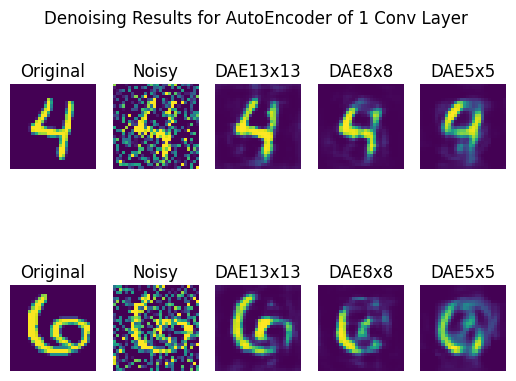

In [77]:
DenoiserPipeline.plot_triple_original_noisy_reconstructed(
    "Denoising Results for AutoEncoder of 1 Conv Layer",
    [images[27], images[54]],
    [noisy[27], noisy[54]],
    [denoised_1_13[27], denoised_1_8[27], denoised_1_5[27]],
    [denoised_1_13[54], denoised_1_8[54], denoised_1_5[54]]
)

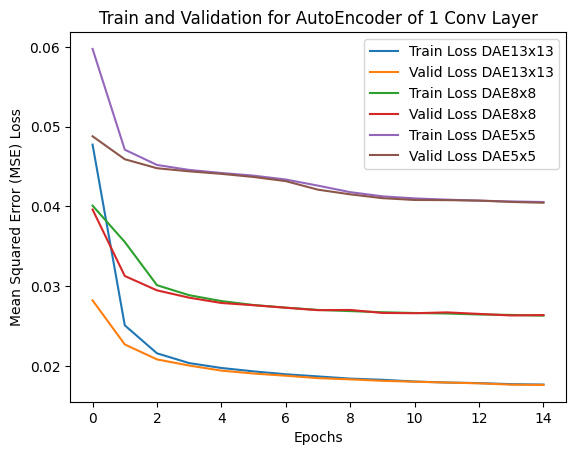

In [78]:
DenoiserPipeline.plot_train_valid_history_for_model_architecture(
    "Train and Validation for AutoEncoder of 1 Conv Layer",
    train_histories = [train_hist_1_13, train_hist_1_8, train_hist_1_5],
    valid_histories = [val_hist_1_13, val_hist_1_8, val_hist_1_5]
)

In [119]:
######################### Models with 5 Conv Layers #########################
test_DAE_5_13 = DAE(seq5_13_13["encoder"], seq5_13_13["decoder"], "DAE_5_13")
test_DAE_5_13.load_state_dict(torch.load('DAE_5_13.pt'))

test_DAE_5_8 = DAE(seq5_8_8["encoder"], seq5_8_8["decoder"], "DAE_5_8")
test_DAE_5_8.load_state_dict(torch.load('DAE_5_8.pt'))

test_DAE_5_5 = DAE(seq5_5_5["encoder"], seq5_5_5["decoder"], "DAE_5_5")
test_DAE_5_5.load_state_dict(torch.load('DAE_5_5.pt'))

######################### Models with 3 Conv Layers #########################
test_DAE_3_13 = DAE(seq3_13_13["encoder"], seq3_13_13["decoder"], "DAE_3_13")
test_DAE_3_13.load_state_dict(torch.load('DAE_3_13.pt'))

test_DAE_3_8 = DAE(seq3_8_8["encoder"], seq3_8_8["decoder"], "DAE_3_8")
test_DAE_3_8.load_state_dict(torch.load('DAE_3_8.pt'))

test_DAE_3_5 = DAE(seq3_5_5["encoder"], seq3_5_5["decoder"], "DAE_3_5")
test_DAE_3_5.load_state_dict(torch.load('DAE_3_5.pt'))

######################### Models with 1 Conv Layers #########################
test_DAE_1_13 = DAE(seq1_13_13["encoder"], seq1_13_13["decoder"], "DAE_1_13")
test_DAE_1_13.load_state_dict(torch.load('DAE_1_13.pt'))

test_DAE_1_8 = DAE(seq1_8_8["encoder"], seq1_8_8["decoder"], "DAE_1_8")
test_DAE_1_8.load_state_dict(torch.load('DAE_1_8.pt'))

test_DAE_1_5 = DAE(seq1_5_5["encoder"], seq1_5_5["decoder"], "DAE_1_5")
test_DAE_1_5.load_state_dict(torch.load('DAE_1_5.pt'))

<All keys matched successfully>

##############################################
Model DAE_5_13 test loss: 0.011216930001974107
Model DAE_5_8 test loss: 0.012617159590125084
Model DAE_5_5 test loss: 0.018194510474801064
Model DAE_3_13 test loss: 0.012096124133467674
Model DAE_3_8 test loss: 0.017288399025797842
Model DAE_3_5 test loss: 0.027160199862718584
Model DAE_1_13 test loss: 0.01728847436904907
Model DAE_1_8 test loss: 0.025790341168642043
Model DAE_1_5 test loss: 0.04009743748307228
##############################################




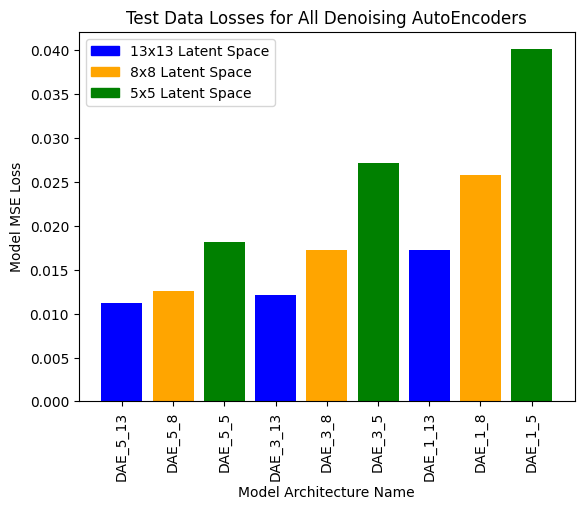

In [135]:
all_models = [test_DAE_5_13, test_DAE_5_8, test_DAE_5_5,
              test_DAE_3_13, test_DAE_3_8, test_DAE_3_5,
              test_DAE_1_13, test_DAE_1_8, test_DAE_1_5]
all_losses = {model.model_name:
              DenoiserPipeline.evaluate_test_model_loss(model, nn.MSELoss(), test_loader, cuda.is_available())
              for model in all_models}

print("##############################################")
for model, loss in all_losses.items():
  print(f"Model {model} test loss: {loss}")
print("##############################################")

print(f"\n")

DenoiserPipeline.plot_test_accuracies(all_losses)